In [1]:
import requests
import time
import json
from datetime import datetime, timedelta
import pytz
import os
from pathlib import Path
import re
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from label_studio_sdk import Client


In [2]:
# get all the start and end epoch times for each day (oct 2024 - oct 2025)

# define timezone
pst = pytz.timezone("America/Los_Angeles")

# start and end dates
start_date = datetime(2024, 10, 1)
end_date = datetime(2025, 10, 1)

# generate epoch times for each midnight
current_date = start_date
epoch_times = []

# record buffer time for each day
buffer = {'oct24': [43, 14, 11, 6, 8, 12, 8, 24, 11, 20, 15, 3, 11, 10, 12,
                    2, 9, 29, 13, 3, 23, 18, 31, 49, 14, 23, 1, 43, 7, 9, 2], 
        'nov24': [6, 7, 24, 2, 11, 5, 7, 13, 8, 11, 11, 40, 11, 3, 8, 
                  15, 2, 17, 1, 5, 23, 46, 41, 6, 1, 43, 10, 11, 3, 10],
        'dec24': [12, 8, 1, 1, 8, 1, 42, 26, 41, 2, 12, 44, 33, 5, 45, 14, 
                  45, 31, 12, 10, 2, 8, 2, 28, 1, 5, 34, 13, 13, 2, 16],
        'jan25': [46, 1, 10, 4, 12, 13, 8, 8, 8, 3, 11, 14, 3, 40, 27, 
                  9, 4, 2, 2, 13, 3, 2, 2, 9, 1, 9, 4, 14, 7, 5, 6], 
        'feb25': [9, 7, 3, 6, 10, 38, 4, 7, 41, 5, 12, 10, 11, 12, 
                  11, 40, 3, 4, 11, 8, 1, 12, 3, 14, 1, 26, 18, 1],
        'mar25': [14, 0, 12, 9, 10, 5, 11, 4, 12, 14, 48, 22, 3, 45, 4, 
                  8, 43, 3, 11, 27, 12, 2, 12, 13, 20, 5, 7, 3, 21, 12, 6], 
        'apr25': [13, 43, 25, 10, 11, 11, 35, 1, 0, 12, 7, 21, 7, 11, 6, 
                    15, 2, 6, 12, 10, 2, 12, 46, 12, 2, 10, 21, 10, 45, 0], 
        'may25': [38, 3, 2, 1, 12, 37, 2, 8, 2, 8, 47, 6, 7, 8, 19, 9, 21, 
                  9, 19, 4, 34, 12, 45, 7, 13, 10, 41, 2, 37, 36, 11], 
        'jun25': [4, 11, 34, 5, 46, 9, 3, 2, 10, 4, 18, 8, 19, 13, 44,
                  10, 45, 9, 36, 6, 10, 39, 2, 29, 1, 18, 13, 7, 16, 19],
        'jul25': [21, 1, 2, 35, 6, 13, 9, 8, 40, 8, 14, 14, 37, 37, 6, 0,
                  12, 0, 1, 23, 6, 2, 11, 2, 10, 11, 5, 36, 12, 10, 28],
        'aug25': [36, 4, 10, 8, 4, 4, 3, 4, 14, 9, 14, 10, 38, 43, 7, 43, 
                  8, 27, 0, 36, 11, 0, 3, 6, 5, 25, 5, 3, 30, 19, 37],
        'sep25': [8, 32, 14, 10, 8, 14, 18, 28, 4, 7, 1, 2, 7, 43, 1, 
                  10, 22, 4, 0, 11, 28, 12, 9, 8, 21, 3, 0, 13, 6, 42]}

# flatten the buffer into a list
buffer_list =  [b for month in buffer.values() for b in month]

i = 0

# generate epoch times for each day at midnight PST with buffer
while current_date < end_date:

    local_dt = pst.localize(datetime(current_date.year, current_date.month, current_date.day, 0, 0, 0))
    # convert to epoch
    epoch_time = int(local_dt.timestamp()) + buffer_list[i]
    epoch_times.append(epoch_time)
    # increment by one day
    current_date += timedelta(days=1)
    i += 1


In [3]:
# # scraping setup
# BASE_URL = "https://tools.alertcalifornia.org/framelist.json"
# HEADERS = {"User-Agent": "dsc180 capstone"}
# SAVE_DIR = "data"

# os.makedirs(SAVE_DIR, exist_ok=True)

# # scape data for each day
# for i in range(len(epoch_times) - 1):
#     start_t = epoch_times[i]
#     end_t = epoch_times[i + 1]
#     date_label = datetime.fromtimestamp(start_t, pst).strftime("%Y%m%d")
#     url = f"{BASE_URL}?id=Axis-CoronadoHillsS&start={start_t}&stop={end_t}"

#     print(f"[{i+1}/{len(epoch_times)-1}] fetching {date_label} ...")

#     try:
#         resp = requests.get(url, headers=HEADERS, timeout=30)
#         resp.raise_for_status()
#         data = resp.json()

#         # save daily JSON
#         file_path = os.path.join(SAVE_DIR, f"{date_label}.json")
#         with open(file_path, "w") as f:
#             json.dump(data, f)

#         print(f"saved {file_path} ({len(data)} records)")
#     except Exception as e:
#         print(f"error fetching {date_label}: {e}")

#     # --- rate limit ---
#     time.sleep(0.2) 

# print("done scraping!")

In [4]:
# convert json file to label studio import format

def json_to_ls(json_file, output_dir, interval=3600):

    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    fn = Path(json_file).stem

    with open(json_file, "r") as f:
        data = json.load(f)

    base_url = "https://tools.alertcalifornia.org"
    paths = data.get("digitalpath-redis", [])

    selected_paths = []
    prev_epoch = None

    for p in paths:

        match = re.search(r'\d{10}', p)
        if not match:
            continue 
        epoch = int(match.group())

        if prev_epoch is None or epoch >= prev_epoch + interval:
            selected_paths.append(p)
            prev_epoch = epoch


    import_data = []

    for sp in selected_paths:
        url = base_url + "/transform" + sp + "?transform=ptz-combo"
        p, t, z = 0, 0, 0

        try:
            resp = requests.get(url, headers={"User-Agent": "dsc180 capstone"}, timeout=10)
            data = resp.json()
            p, t, z = data.get("ptz")

        except Exception as e:
            print(f"error fetching PTZ for {sp}: {e}")
            continue

        import_data.append({"image": base_url + sp,
                            "ptz": {"pan": p, "tilt": t, "zoom": z}})

        time.sleep(0.1) # rate limit
    
    out_file = output_path / f"{fn}_import.json"
    with open(out_file, "w") as f:
        json.dump(import_data, f, indent=2)

    return f"{out_file} saved"

In [5]:
# # convert all json files in data folder to label studio import format

# data_path = Path("data")
# json_files = data_path.glob("*.json")

# for file in json_files:
#     processed = json_to_ls(file, 'import_data_ptz')
#     print(processed)

# print("all processed!")

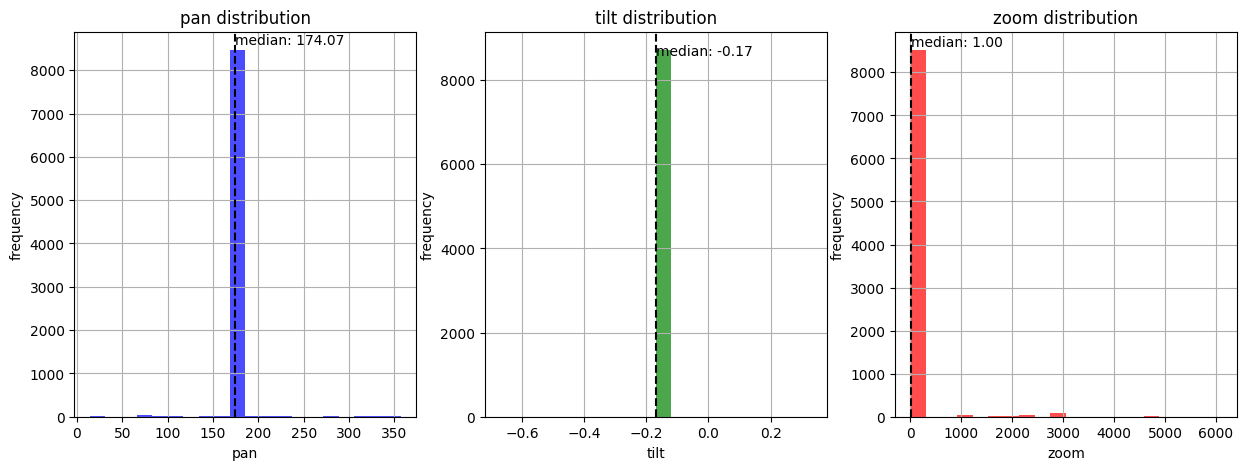

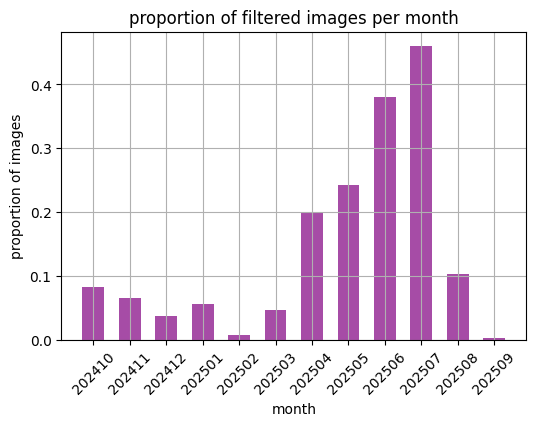

In [6]:
ptz_data_path = Path("import_data_ptz")
ptz_files = ptz_data_path.glob("*.json")

df = pd.DataFrame()
thresholds = {'pan': 4, 'tilt': 0.1, 'zoom': 0.1}
filtered_counts = defaultdict(int)
monthly_counts = defaultdict(int)

for file in ptz_files:
    month = file.stem[:6]
    with open(file, "r") as f:
        data = json.load(f)

    temp_df = pd.json_normalize(data)
    df = pd.concat([df, temp_df], ignore_index=True)

    for entry in data:
        p = entry['ptz']['pan']
        t = entry['ptz']['tilt']
        z = entry['ptz']['zoom']

        monthly_counts[month] += 1

        if abs(p - df['ptz.pan'].median()) > thresholds['pan'] or \
           abs(t - df['ptz.tilt'].median()) > thresholds['tilt'] or \
           abs(z - df['ptz.zoom'].median()) > thresholds['zoom']:
            
            filtered_counts[month] += 1
            

# create histogram of pan, tilt, zoom values and the 
plt.figure(figsize=(15, 5))

# pan histogram
plt.subplot(1, 3, 1)
plt.hist(df['ptz.pan'], bins=20, color='blue', alpha=0.7)
plt.title('pan distribution')
plt.xlabel('pan')
plt.ylabel('frequency')
plt.grid()
plt.axvline(df['ptz.pan'].median(), color='k', linestyle='dashed')
median_pan = df['ptz.pan'].median()
plt.text(median_pan, 8600, f'median: {median_pan:.2f}', rotation=0)

# tilt histogram
plt.subplot(1, 3, 2)
plt.hist(df['ptz.tilt'], bins=20, color='green', alpha=0.7)
plt.title('tilt distribution')
plt.xlabel('tilt')
plt.ylabel('frequency')
plt.grid()
plt.axvline(df['ptz.tilt'].median(), color='k', linestyle='dashed')
median_tilt = df['ptz.tilt'].median()
plt.text(median_tilt, 8600, f'median: {median_tilt:.2f}', rotation=0)

# zoom histogram
plt.subplot(1, 3, 3)
plt.hist(df['ptz.zoom'], bins=20, color='red', alpha=0.7)
plt.title('zoom distribution')
plt.xlabel('zoom')
plt.ylabel('frequency')
plt.grid()
plt.axvline(df['ptz.zoom'].median(), color='k', linestyle='dashed')
median_zoom = df['ptz.zoom'].median()
plt.text(median_zoom, 8600, f'median: {median_zoom:.2f}', rotation=0)

plt.show()

# plot the proportion of filtered images per month
months = sorted(monthly_counts.keys())
counts = [filtered_counts[m] / monthly_counts[m] for m in months]
plt.figure(figsize=(6, 4))
plt.bar(months, counts, color='purple', alpha=0.7, width=0.6)
plt.title('proportion of filtered images per month')
plt.xlabel('month')
plt.ylabel('proportion of images')
plt.grid()
plt.xticks(rotation=45)
plt.show()
    

In [7]:
# filter the json files so that only the ptz values that fall within threshold are kept

def combine_and_filter_jsons(json_files, output_dir, pan_range, tilt_range, zoom_range):
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    monthly_groups = defaultdict(list)
    for file in json_files:
        file = Path(file)
        match = re.search(r"(\d{4})(\d{2})\d{2}_import\.json$", file.name)
        if not match:
            print(f"skipping unrecognized filename format: {file.name}")
            continue

        year, month = match.groups()
        month_key = f"{year}-{month}"
        monthly_groups[month_key].append(file)

    
    for month, files in monthly_groups.items():
        combined_data = []

        for fpath in files:
            try:
                with open(fpath, "r") as f:
                    data = json.load(f)
                    
            except Exception as e:
                print(f"error reading {fpath}: {e}")
                continue

            # filter ptz values
            for item in data:
                try:
                    p = item["ptz"]["pan"]
                    t = item["ptz"]["tilt"]
                    z = item["ptz"]["zoom"]

                except Exception as e:
                    print(f'error: {e}')
                    continue

                if (pan_range[0] <= p <= pan_range[1] and
                    tilt_range[0] <= t <= tilt_range[1] and
                    zoom_range[0] <= z <= zoom_range[1]):
                    combined_data.append(item)

        # save monthly combined JSON
        out_file = output_path / f"{month}-import.json"
        with open(out_file, "w") as f:
            json.dump(combined_data, f, indent=2)
            print(f"{out_file} saved with {len(combined_data)} records")


    print("all months processed successfully")


In [8]:
# # filter for correct ptz values and combine into monthly jsons1

# input_dir = Path("import_data_ptz") 
# output_dir = Path("filtered_data")

# json_files = sorted(input_dir.glob("*_import.json"))

# combine_and_filter_jsons(json_files, output_dir, (170, 178), (-0.18, -0.16), (0.99, 1.01))


In [9]:
# connect to label studio projects 

LABEL_STUDIO_URL = "https://labeler.rd.alertcalifornia.org/"
API_KEY = "59932e8b47e7ff204835b5b3eb2ca281f2fb08ec"

PROJ1_ID = 16
PROJ2_ID = 17

ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)

proj1 = ls.get_project(PROJ1_ID)
proj2 = ls.get_project(PROJ2_ID)

print(f"connected to label studio at {LABEL_STUDIO_URL}")
print(f"project1: {proj1.title}, project2: {proj2.title}")

connected to label studio at https://labeler.rd.alertcalifornia.org/
project1: DSC 180A – Coronado Hills S (Binary), project2: DSC 180A – Coronado Hills S (PTZ Filtered)


In [11]:
# sync annotations from project1 to project2

tasks2 = proj1.get_tasks() 
tasks1 = proj2.get_tasks()

print(f"project1 tasks: {len(tasks1)}, project2 tasks: {len(tasks2)}")

# get the unique image urls for each task
def get_key(task):
    return task["data"].get("image")

# create a dictionary pair if task from project1 has annotations
proj1_annotations = {
    get_key(t): t
    for t in tasks1
    if t.get("annotations")
}

merged_count = 0
for t2 in tasks2:
    key = get_key(t2)
    if key in proj1_annotations:
        if not t2.get("annotations"):

            # copy annotations from project1
            copied_annotations = proj1_annotations[key]["annotations"]
            for ann in copied_annotations:
                if ann.get("result") is not None:
                    ann.pop("id", None)
                    ann.pop("task", None)
                    proj2.create_annotation(task_id=t2["id"], result=ann["result"])
                    merged_count += 1

print(f"{merged_count} annotations copied from {proj1.title} → {proj2.title}")

